---
title: "[stock prediction] 3.2 t-SNE를 사용한 주가데이터 2차원 시각화"
author: "agsu"
date: "7/22/2022"
format: 
  html:
    code-fold: false
jupyter: python3
categories: [project, stock prediction]
image: ../image/stock7.png
---

# 3. 논문 연구: 주가 상승추세 패턴 검출   
## 3.2. t-SNE를 사용한 주가데이터 2차원 시각화
이전 글 ( [3.1. 설명가능 AI (XAI), SHAP value](https://ag-su.github.io/blog/posts/06.shap_value.html) ) 에서는 `XAI` 기법 중 하나인 `SHAP`을 사용하여 변수 중요도를 계산하고, `summary plot`의 결과로 데이터를 필터링하여 특정 집단을 구성해보았다. 이번 글에서는 주가 데이터셋과, SHAP표준화 데이터셋을 **2차원 평면에 시각화**함으로써 집단 형성이 이루어지는 것을 확인한다. 

### 목차 
- (1) SHAP 표준화 데이터셋
- (2) T-SNE를 사용한 2차원 시각화 비교 (원본 데이터셋 vs SHAP transform 데이터셋)

- 라이브러리 import  

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import pymysql

import warnings
warnings.filterwarnings('ignore')

from ipywidgets import interact, interact_manual
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.offline as pyo
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (12,5)

import StockFunc as sf

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


<br>
<br>

## (1) SHAP 표준화 데이터셋 
`SHAP 표준화 데이터셋`이란 주가 예측 머신러닝 모델(XGBoost)로 각 데이터에 대한 `Shap value`를 계산하여 기존의 주가 데이터셋을 변환한 데이터를 말한다. 기존 주가 데이터가 SHAP 표준화 데이터로 변환되었을 때, **이진분류 주가 예측 모델의 중요 변수를 상대적으로 가중하게됨으로써 데이터에서의 내재되어있는 패턴이 강조되는 효과**가 있다. 따라서 기존의 `주가 데이터셋`과 `SHAP 표준화 데이터셋`을 2차원 평면에 함께 시각화 하여 `SHAP 표준화 데이터셋`의 군집의 경계가 더 명확하게 드러나는 것을 확인한다. 

- CCI 구간 별 주가 데이터셋 불러오기

In [2]:
import pickle
with open('dataset_cci_filtering.pickle', 'rb') as handle:
    dic_dataset_model = pickle.load(handle)

CCI filtering 글에서 생성한 CCI 구간 별 데이터셋과 모델을 불러온다.  

- 컬럼 리스트 생성

In [2]:
#collapse-hide
lst_col_info = []

lst_col = ['Open', 'High', 'Low', 'Close', 'trading_value', 'MA5', 'MA20', 'MA60', 'MA120', 
           'VMAP', 'BHB', 'BLB', 'KCH', 'KCL', 'KCM', 'DCH', 'DCL', 'DCM',
           'SMA', 'EMA', 'WMA', 'Ichimoku', 'Parabolic SAR', 'KAMA','MACD']   +  ['Change', 'Volume', 'MFI', 'ADI', 'OBV', 
                                                                                   'CMF', 'FI', 'EOM, EMV', 'VPT', 'NVI', 'ATR', 'UI',
                                                                                   'ADX', '-VI', '+VI', 'TRIX', 'MI', 'CCI', 'DPO', 'KST', 
                                                                                   'STC', 'RSI', 'SRSI', 'TSI', 'UO', 'SR',
                                                                                   'WR', 'AO', 'ROC', 'PPO', 'PVO'] 
           

for day in range(9, -1, -1): 
    for col in lst_col: 
        lst_col_info.append(f'D-{day}_{col}')

뒤에서 1년 단위로 2차원 시각화를 하기 위해 `train, test` 데이터셋을 합치고, 각 `CCI` 구간 별 `SHAP transform` 데이터를 생성한다.  

<br>

### 1) 중립구간 - CCI : (-20, 20)

In [4]:
trainX_1, trainY_1, testX_1, testY_1, lst_code_date_1, lst_code_date_test_1, xgb_1 = dic_dataset_model['CCI -20~20']
print('train dataset: ', trainX_1.shape, trainY_1.shape)
print('test dataset: ', testX_1.shape, testY_1.shape)

train dataset:  (123321, 560) (123321,)
test dataset:  (36885, 560) (36885,)


- code, date, label컬럼 추가 및 train, test을 합친 데이터프레임 생성

In [5]:
#collapse-hide
# train + test (array)
arr_data_1 = np.concatenate((trainX_1, testX_1), axis=0)
arr_label_1 = np.concatenate((trainY_1, testY_1), axis=0)
arr_code_date_1 = np.concatenate((lst_code_date_1, lst_code_date_test_1), axis=0)

# code + date + dataset + label (dataframe)
df_data_1 = pd.DataFrame(arr_data_1, columns=lst_col_info)
df_data_1['Code'], df_data_1['Date'], df_data_1['Label'] = arr_code_date_1[:, 0], arr_code_date_1[:, 1], arr_label_1
df_data_1 = df_data_1[['Code', 'Date'] + lst_col_info + ['Label']]

print('df_data_1 shape:', df_data_1.shape)
display(df_data_1.head())

df_data_1 shape: (160206, 563)


Code        Date  D-9_Open  D-9_High   D-9_Low  D-9_Close  \
0  050120  2017-01-20  1.005714  1.048000  1.000000   1.040000   
1  050120  2017-02-06  1.000000  1.011236  0.974157   0.988764   
2  050120  2017-02-24  1.007463  1.012793  0.996802   1.005330   
3  050120  2017-02-27  1.007423  1.033934  0.975610   1.033934   
4  050120  2017-02-28  0.994872  0.994872  0.950769   0.974359   

   D-9_trading_value   D-9_MA5  D-9_MA20  D-9_MA60  ...  D-0_SRSI    D-0_TSI  \
0      462369.440000  0.994514  0.968971  0.981010  ...  0.057077  20.137832   
1       94755.235955  1.004719  0.987640  0.954307  ...  0.779487   6.199506   
2      105709.495736  0.974840  0.944350  0.910856  ...  0.000000  16.267954   
3      327239.156946  0.987063  0.943160  0.907971  ...  0.225976  14.411703   
4      168981.128205  0.966974  0.914769  0.879402  ...  0.108960  11.827189   

      D-0_UO     D-0_SR     D-0_WR      D-0_AO   D-0_ROC   D-0_PPO    D-0_PVO  \
0  43.856662  46.236559 -53.763441  433.235294  2.564103  1.624561  -3.039166   
1  48.326356  75.903614 -24.096386   53.588235 -0.885936  0.530558   2.429462   
2  46.534386  14.444444 -85.555556  343.500000  0.898876  1.645809  10.986297   
3  44.991463  40.909091 -59.090909  289.705882  1.651982  1.484638   9.126668   
4  44.008782  26.136364 -73.863636  221.794118 -2.985075  1.229302   5.503306   

   Label  
0      0  
1      0  
2      1  
3      0  
4      0  

[5 rows x 563 columns]

- SHAP transform 데이터셋 생성 

In [6]:
#collapse-hide
import shap
shap.initjs()
explainer = shap.TreeExplainer(xgb_1)
shap_values = explainer.shap_values(df_data_1.drop(columns=['Code', 'Date', 'Label']))

df_shap_values_1 = pd.DataFrame(shap_values, columns=lst_col_info)
df_shap_values_1['Code'], df_shap_values_1['Date'], df_shap_values_1['Label'] = arr_code_date_1[:, 0], arr_code_date_1[:, 1], arr_label_1
df_shap_values_1 = df_shap_values_1[['Code', 'Date'] + lst_col_info + ['Label']]

print('df_shap_values_1 shape:', df_shap_values_1.shape)
display(df_shap_values_1.head())

df_shap_values_1 shape: (160206, 563)


Code        Date  D-9_Open  D-9_High   D-9_Low  D-9_Close  \
0  050120  2017-01-20 -0.007915 -0.001929 -0.000805   0.001416   
1  050120  2017-02-06 -0.007741 -0.001461  0.000470   0.000085   
2  050120  2017-02-24 -0.009699 -0.001854 -0.000975  -0.000129   
3  050120  2017-02-27 -0.008703 -0.001563  0.000816   0.000360   
4  050120  2017-02-28 -0.003862  0.007390  0.000849   0.000148   

   D-9_trading_value  D-9_MA5  D-9_MA20  D-9_MA60  ...  D-0_SRSI  D-0_TSI  \
0          -0.000197      0.0  0.000018 -0.000571  ...       0.0      0.0   
1          -0.000197      0.0  0.000012 -0.000229  ...       0.0      0.0   
2          -0.000197      0.0  0.000018 -0.000571  ...       0.0      0.0   
3          -0.000197      0.0  0.000018 -0.000571  ...       0.0      0.0   
4          -0.000197      0.0  0.000018 -0.000571  ...       0.0      0.0   

     D-0_UO    D-0_SR  D-0_WR    D-0_AO   D-0_ROC   D-0_PPO   D-0_PVO  Label  
0  0.003014  0.000004     0.0  0.000062 -0.003845  0.000004 -0.001181      0  
1  0.001020  0.000009     0.0  0.000052  0.004082  0.000004  0.007927      0  
2  0.001876 -0.000005     0.0  0.000062 -0.004085  0.000004  0.007150      1  
3  0.001332  0.000009     0.0  0.000062 -0.003878  0.000004  0.008917      0  
4  0.001248 -0.000005     0.0  0.000062  0.004082  0.000004  0.008872      0  

[5 rows x 563 columns]

<br>

### 2) 과열구간/과매수구간 - CCI : (100,  ∞ )

In [9]:
trainX_2, trainY_2, testX_2, testY_2, lst_code_date_2, lst_code_date_test_2, xgb_2 = dic_dataset_model['CCI 100~']
print('train dataset: ', trainX_2.shape, trainY_2.shape)
print('test dataset: ', testX_2.shape, testY_2.shape)

train dataset:  (256399, 560) (256399,)
test dataset:  (64768, 560) (64768,)


- code, date, label컬럼 추가 및 train, test을 합친 데이터프레임 생성 

In [10]:
#collapse-hide
# train + test (array)
arr_data_2 = np.concatenate((trainX_2, testX_2), axis=0)
arr_label_2 = np.concatenate((trainY_2, testY_2), axis=0)
arr_code_date_2 = np.concatenate((lst_code_date_2, lst_code_date_test_2), axis=0)

# code + date + dataset + label (dataframe)
df_data_2 = pd.DataFrame(arr_data_2, columns=lst_col_info)
df_data_2['Code'], df_data_2['Date'], df_data_2['Label'] = arr_code_date_2[:, 0], arr_code_date_2[:, 1], arr_label_2
df_data_2 = df_data_2[['Code', 'Date'] + lst_col_info + ['Label']]

print('df_data_2 shape:', df_data_2.shape)
display(df_data_2.head())

df_data_2 shape: (321167, 563)


Code        Date  D-9_Open  D-9_High   D-9_Low  D-9_Close  \
0  050120  2017-02-10  1.014235  1.014235  0.990510   1.002372   
1  050120  2017-02-13  0.984615  1.023669  0.984615   0.997633   
2  050120  2017-02-14  0.990510  1.064057  0.990510   1.026097   
3  050120  2017-02-15  0.996532  1.040462  0.996532   1.038150   
4  050120  2017-02-16  1.013363  1.013363  0.982183   0.983296   

   D-9_trading_value   D-9_MA5  D-9_MA20  D-9_MA60  ...  D-0_SRSI    D-0_TSI  \
0       50865.391459  1.012100  1.039442  1.004251  ...  1.000000  14.884190   
1       55152.152663  1.000947  1.036391  1.002367  ...  1.000000  18.642720   
2       78619.572954  1.007355  1.039739  1.005575  ...  1.000000  23.963771   
3      210838.980347  0.992832  1.016358  0.980732  ...  0.721663  25.077575   
4      303571.073497  0.965256  0.980401  0.944933  ...  0.774168  26.576492   

      D-0_UO      D-0_SR     D-0_WR      D-0_AO    D-0_ROC   D-0_PPO  \
0  55.338001  100.952381   0.952381  223.411765  10.613208  1.337481   
1  51.178165   94.067797  -5.932203  310.029412  10.941176  1.688808   
2  66.127796  100.000000  -0.000000  393.558824  15.658363  2.221982   
3  61.734791   82.517483 -17.482517  451.588235  12.426036  2.389092   
4  63.519219   89.510490 -10.489510  525.558824  13.879004  2.576580   

     D-0_PVO  Label  
0   6.227088      0  
1   4.010564      1  
2  14.120940      0  
3  13.705978      0  
4  18.168169      0  

[5 rows x 563 columns]

- SHAP transform 데이터셋 생성 

In [11]:
#collapse-hide
import shap
shap.initjs()
explainer = shap.TreeExplainer(xgb_2)
shap_values = explainer.shap_values(df_data_2.drop(columns=['Code', 'Date', 'Label']))

df_shap_values_2 = pd.DataFrame(shap_values, columns=lst_col_info)
df_shap_values_2['Code'], df_shap_values_2['Date'], df_shap_values_2['Label'] = arr_code_date_2[:, 0], arr_code_date_2[:, 1], arr_label_2
df_shap_values_2 = df_shap_values_2[['Code', 'Date'] + lst_col_info + ['Label']]

print('df_shap_values_2 shape:', df_shap_values_2.shape)
display(df_shap_values_2.head())

df_shap_values_2 shape: (321167, 563)


Code        Date  D-9_Open      D-9_High   D-9_Low  D-9_Close  \
0  050120  2017-02-10 -0.000128  1.306584e-06 -0.002761        0.0   
1  050120  2017-02-13  0.002046 -8.618027e-07 -0.002228        0.0   
2  050120  2017-02-14 -0.000148 -8.618027e-07 -0.002317        0.0   
3  050120  2017-02-15 -0.000173 -8.618027e-07 -0.002759        0.0   
4  050120  2017-02-16 -0.000172  1.306584e-06 -0.001784        0.0   

   D-9_trading_value   D-9_MA5  D-9_MA20  D-9_MA60  ...  D-0_SRSI   D-0_TSI  \
0           0.000007  0.000003  0.000001       0.0  ... -0.001276  0.000247   
1           0.000004 -0.000001  0.000001       0.0  ... -0.000481  0.000249   
2           0.000007  0.000041  0.000001       0.0  ... -0.000370  0.000249   
3           0.000046 -0.000001  0.000001       0.0  ...  0.000536  0.000249   
4           0.000024 -0.000020  0.000001       0.0  ...  0.000400 -0.000031   

   D-0_UO    D-0_SR  D-0_WR    D-0_AO   D-0_ROC   D-0_PPO   D-0_PVO  Label  
0     0.0 -0.010375     0.0  0.000695 -0.005244  0.001141 -0.002147      0  
1     0.0 -0.011002     0.0  0.000695 -0.005244  0.001374 -0.002653      1  
2     0.0 -0.011764     0.0  0.000695 -0.002502  0.001067 -0.002653      0  
3     0.0 -0.012226     0.0  0.000695 -0.005757  0.001003 -0.003974      0  
4     0.0 -0.011209     0.0  0.000255 -0.004513  0.000797  0.010798      0  

[5 rows x 563 columns]

<br>

### 3) 침체구간/과매도구간 - CCI : (- ∞ ,-100)

In [12]:
trainX_3, trainY_3, testX_3, testY_3, lst_code_date_3, lst_code_date_test_3, xgb_3 = dic_dataset_model['CCI ~-100']
print('train dataset: ', trainX_3.shape, trainY_3.shape)
print('test dataset: ', testX_3.shape, testY_3.shape)

train dataset:  (269977, 560) (269977,)
test dataset:  (73435, 560) (73435,)


- code, date, label컬럼 추가 및 train, test을 합친 데이터프레임 생성 

In [13]:
#collapse-hide
# train + test (array)
arr_data_3 = np.concatenate((trainX_3, testX_3), axis=0)
arr_label_3 = np.concatenate((trainY_3, testY_3), axis=0)
arr_code_date_3 = np.concatenate((lst_code_date_3, lst_code_date_test_3), axis=0)

# code + date + dataset + label (dataframe)
df_data_3 = pd.DataFrame(arr_data_3, columns=lst_col_info)
df_data_3['Code'], df_data_3['Date'], df_data_3['Label'] = arr_code_date_3[:, 0], arr_code_date_3[:, 1], arr_label_3
df_data_3 = df_data_3[['Code', 'Date'] + lst_col_info + ['Label']]

print('df_data_3 shape:', df_data_3.shape)
display(df_data_3.head())

df_data_3 shape: (343412, 563)


Code        Date  D-9_Open  D-9_High   D-9_Low  D-9_Close  \
0  050120  2017-01-25  0.991238  1.004381  0.971522   0.980285   
1  050120  2017-05-18  1.019084  1.019084  0.938931   0.946565   
2  050120  2017-05-19  0.991935  1.040323  0.987903   1.004032   
3  050120  2017-05-22  1.000000  1.020080  0.979920   0.991968   
4  050120  2017-05-23  1.004049  1.004049  0.955466   0.979757   

   D-9_trading_value   D-9_MA5  D-9_MA20  D-9_MA60  ...  D-0_SRSI   D-0_TSI  \
0      140309.140197  0.984885  0.943045  0.936528  ...  0.000000  5.486901   
1      690931.786260  0.964885  0.889427  0.787226  ...  0.022302  7.541308   
2      317878.620968  1.026613  0.945484  0.836371  ...  0.000000  3.945359   
3      350971.128514  1.012851  0.946787  0.837590  ...  0.000000 -1.153744   
4      327074.267206  1.010526  0.958907  0.848691  ...  0.041239 -4.753380   

      D-0_UO     D-0_SR      D-0_WR      D-0_AO    D-0_ROC   D-0_PPO  \
0  35.175106   8.421053  -91.578947   86.911765  -7.362637  0.401602   
1  40.870588  10.000000  -90.000000   43.235294 -13.127413  1.251577   
2  39.056401   1.960784  -98.039216 -168.382353 -13.725490  0.615608   
3  34.272840   0.000000 -100.000000 -473.676471 -20.610687 -0.308624   
4  32.124091   4.761905  -95.238095 -627.794118 -15.322581 -0.969999   

     D-0_PVO  Label  
0 -13.360869      0  
1  -3.674717      0  
2  -4.840261      0  
3  -0.268302      0  
4   0.192505      0  

[5 rows x 563 columns]

- SHAP transform 데이터셋 생성 

In [14]:
#collapse-hide
import shap
shap.initjs()
explainer = shap.TreeExplainer(xgb_3)
shap_values = explainer.shap_values(df_data_3.drop(columns=['Code', 'Date', 'Label']))

df_shap_values_3 = pd.DataFrame(shap_values, columns=lst_col_info)
df_shap_values_3['Code'], df_shap_values_3['Date'], df_shap_values_3['Label'] = arr_code_date_3[:, 0], arr_code_date_3[:, 1], arr_label_3
df_shap_values_3 = df_shap_values_3[['Code', 'Date'] + lst_col_info + ['Label']]

print('df_shap_values_3 shape:', df_shap_values_3.shape)
display(df_shap_values_3.head())

df_shap_values_3 shape: (343412, 563)


Code        Date  D-9_Open  D-9_High  D-9_Low  D-9_Close  \
0  050120  2017-01-25       0.0  0.000021      0.0   0.001773   
1  050120  2017-05-18       0.0  0.000238      0.0  -0.032219   
2  050120  2017-05-19       0.0  0.000282      0.0   0.001756   
3  050120  2017-05-22       0.0  0.000177      0.0   0.001917   
4  050120  2017-05-23       0.0 -0.000847      0.0   0.002323   

   D-9_trading_value   D-9_MA5  D-9_MA20  D-9_MA60  ...  D-0_SRSI  D-0_TSI  \
0                0.0 -0.000586       0.0 -0.000619  ...  0.000374      0.0   
1                0.0 -0.000341       0.0 -0.000356  ...  0.000017      0.0   
2                0.0  0.000070       0.0 -0.000222  ...  0.000374      0.0   
3                0.0  0.000153       0.0 -0.000356  ...  0.000374      0.0   
4                0.0  0.001116       0.0 -0.001705  ...  0.000856      0.0   

     D-0_UO    D-0_SR  D-0_WR  D-0_AO   D-0_ROC  D-0_PPO   D-0_PVO  Label  
0  0.004017 -0.024822     0.0     0.0 -0.011074      0.0  0.000174      0  
1  0.003150 -0.035779     0.0     0.0  0.019929      0.0  0.000174      0  
2  0.004979  0.058416     0.0     0.0  0.019747      0.0  0.000174      0  
3  0.003013  0.243910     0.0     0.0  0.019765      0.0  0.000029      0  
4  0.002451 -0.002878     0.0     0.0  0.024483      0.0  0.000029      0  

[5 rows x 563 columns]

- 모든 dataframe 저장 

In [37]:
#collapse-hide
import pickle 
dict_all_dataset = {1: [df_data_1, df_shap_values_1],
                  2: [df_data_2, df_shap_values_2],
                  3: [df_data_3, df_shap_values_3]}

with open(f'all_dataset', 'wb') as handle:
    pickle.dump(dict_all_dataset, handle, protocol=pickle.HIGHEST_PROTOCOL)

<br>
<br>

## (2) T-SNE를 사용한 2차원 시각화 비교 (원본 데이터셋 vs SHAP 표준화 데이터셋)
2차원 시각화는 **CCI 구간별, 연도별**로 데이터를 분할하여 진행한다. 이 때 원본 주가 데이터셋과 SHAP 표준화 데이터셋을 같이 시각화하여 군집이 형성되는 형태를 비교한다. 


데이터 분할에 사용되는 CCI 구간, 연도는 다음과 같다. 

***CCI 구간**   
**`1) 중립구간`** - CCI : (-20, 20)   
**`2) 과열구간`** - CCI : (100, $\infty$)   
**`3) 침체 구간`** - CCI : (-$\infty$,-100)   

***연도**   
**`1) 2019년`**  
**`2) 2020년`**  
**`3) 2021년`**  

- t-SNE 2차원 시각화 함수 생성   

원본 주가 데이터셋과 SHAP 표준화 데이터셋, 연도, cci 구간 정보를 넣어주면, 두 데이터셋에 대한 2차원 시각화 결과를 반환하는 함수를 생성한다. 시간 단축을 위해 최초 실행할 때 `tsne_load=False`로 설정하여 tsne 데이터를 저장하고, `tsne_loae=True`로 바꾸어 바로 시각화 할 수 있도록 한다. 2차원 시각화 할 때는 label별로 색깔을 다르게 지정하여 **특정 label의 분포가 집중되어 있는 군집이 존재하는지** 확인한다.

In [26]:
def tsne_visualization(dataset, shap_dataset, year, cci_type, tsne_load=False, alpha=0.4, size=3):
    """
    dataset: pd.DataFrame() / 원본 주가 데이터셋 
    shap_dataset: pd.DataFrame() / SHAP 표준화 데이터셋
    year: Int / 시각화 할 연도 
    cci_type: Int / 1(중립구간), 2(과열구간), 3(침체구간) - 파일 저장 및 로드를 위함 
    tsne_load(default:True): Boolean / False: 최초 실행 시 tsne data 생성 후 저장, True: 저장된 tsne data를 불러와서 시각화 - 시간 절약을 위함 
    alpha(default:0.4): Float / 투명도 
    size=3(default:3): Int / 점 크기 
    """
    
    from sklearn.manifold import TSNE
    import pickle 
    plt.rcParams['axes.unicode_minus'] = False
    plt.rc('font', family='NanumGothic')
    # plt.style.use('default')
    
    fig = plt.figure(figsize=(15, 5))
    ax1, ax2 = fig.subplots(1, 2)
    
    ##### 원본 데이터 #####
    dataset_year = dataset[(dataset['Date'] >= f'{year}-01-01') & (dataset['Date'] <= f'{year}-12-31')].reset_index(drop=True)
    
    if not tsne_load:
        np_tsne = TSNE(n_components=2, random_state=42).fit_transform(dataset_year.drop(columns=['Code', 'Date', 'Label'])) # 2차원 t-sne 임베딩  
        # save np_tsne
        with open(f'np_tsne_{year}_{cci_type}', 'wb') as handle:
            pickle.dump(np_tsne, handle, protocol=pickle.HIGHEST_PROTOCOL)
    else: 
        # load np_tsne
        with open(f'np_tsne_{year}_{cci_type}', 'rb') as handle:
            np_tsne = pickle.load(handle)
    
    df_tsne = pd.DataFrame(np_tsne, columns=['component0', 'component1']) # numpy array -> Dataframe     
    df_tsne['Label'] = dataset_year['Label'] # Label 정보 불러오기

    # Label 별 분리 
    df_tsne_0 = df_tsne[df_tsne['Label']==0]
    df_tsne_1 = df_tsne[df_tsne['Label']==1]

    # Label 별 시각화 
    ax1.scatter(df_tsne_0['component0'], df_tsne_0['component1'], color = 'green', label = 'Label 0', alpha=alpha, s=size)
    ax1.scatter(df_tsne_1['component0'], df_tsne_1['component1'], color = 'pink', label = 'Label 1', alpha=alpha, s=size)

    ax1.set_title('원본 데이터셋')
    ax1.set_xlabel('component 0')
    ax1.set_ylabel('component 1')
    ax1.legend()
    
    ##### SHAP transform data #####
    shap_dataset_year = shap_dataset[(shap_dataset['Date'] >= f'{year}-01-01') & (shap_dataset['Date'] <= f'{year}-12-31')].reset_index(drop=True)
    
    if not tsne_load:
        np_tsne_shap = TSNE(n_components=2, random_state=42).fit_transform(shap_dataset_year.drop(columns=['Code', 'Date', 'Label'])) # 2차원 t-sne 임베딩  
        # save np_tsne
        with open(f'np_tsne_shap_{year}_{cci_type}', 'wb') as handle:
            pickle.dump(np_tsne_shap, handle, protocol=pickle.HIGHEST_PROTOCOL)
    else: 
        # load np_tsne
        with open(f'np_tsne_shap_{year}_{cci_type}', 'rb') as handle:
            np_tsne_shap = pickle.load(handle)
   
    df_tsne_shap = pd.DataFrame(np_tsne_shap, columns=['component0', 'component1']) # numpy array -> Dataframe     
    df_tsne_shap['Label'] = shap_dataset_year['Label'] # Label 정보 불러오기

    # Label 별 분리 
    df_tsne_shap_0 = df_tsne_shap[df_tsne_shap['Label']==0]
    df_tsne_shap_1 = df_tsne_shap[df_tsne_shap['Label']==1]

    # Label 별 시각화 
    ax2.scatter(df_tsne_shap_0['component0'], df_tsne_shap_0['component1'], color = 'green', label = 'Label 0', alpha=alpha, s=size)
    ax2.scatter(df_tsne_shap_1['component0'], df_tsne_shap_1['component1'], color = 'pink', label = 'Label 1', alpha=alpha, s=size)

    ax2.set_title('SHAP transform 데이터셋')
    ax2.set_xlabel('component 0')
    ax2.set_ylabel('component 1')
    ax2.legend()   
    
    
    plt.show()

<br>


CCI 구간 별, 연도 별 t-SNE 시각화를 진행한다. 원본 데이터셋과 SHAP transform 데이터셋의 그림을 비교하여 집단 형성이 이루어지는지 확인한다.

<br>

### 1) 중립구간 - CCI : (-20, 20)

#### I. 2019

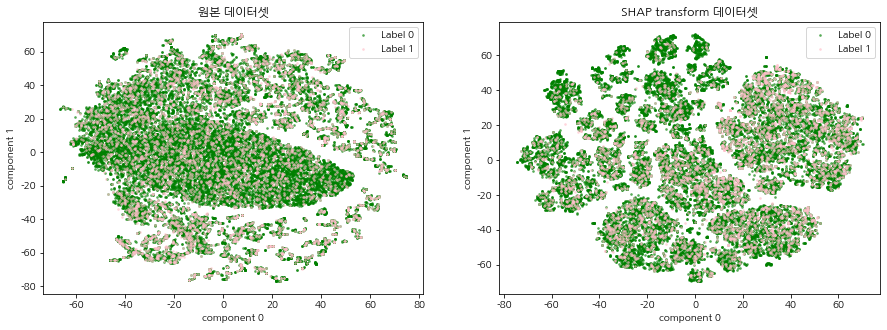

In [36]:
tsne_visualization(dataset=df_data_1, shap_dataset=df_shap_values_1, year=2019, cci_type=1, tsne_load=True, alpha=0.5, size=3)

#### II. 2020

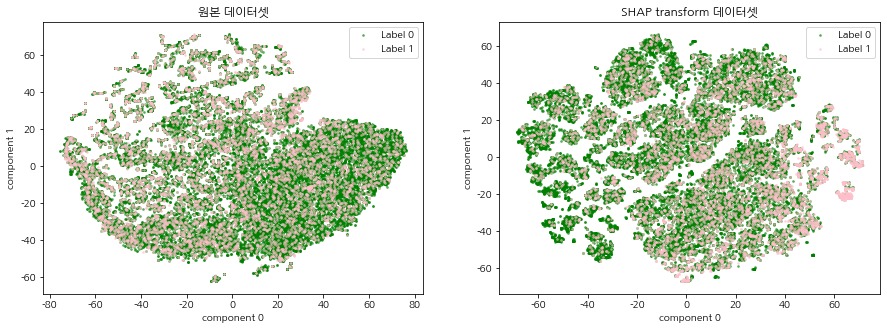

In [35]:
tsne_visualization(dataset=df_data_1, shap_dataset=df_shap_values_1, year=2020, cci_type=1, tsne_load=True, alpha=0.5, size=3)

#### III. 2021

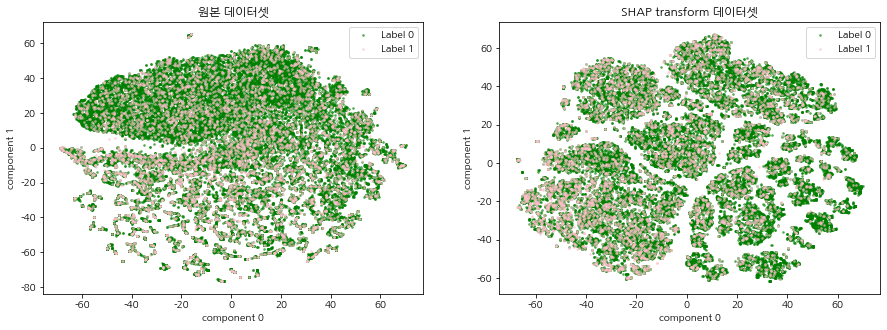

In [34]:
tsne_visualization(dataset=df_data_1, shap_dataset=df_shap_values_1, year=2021, cci_type=1, tsne_load=True, alpha=0.5, size=3)

<br>

### 2) 과열구간/과매수구간 - CCI : (100,  ∞ )

#### I. 2019

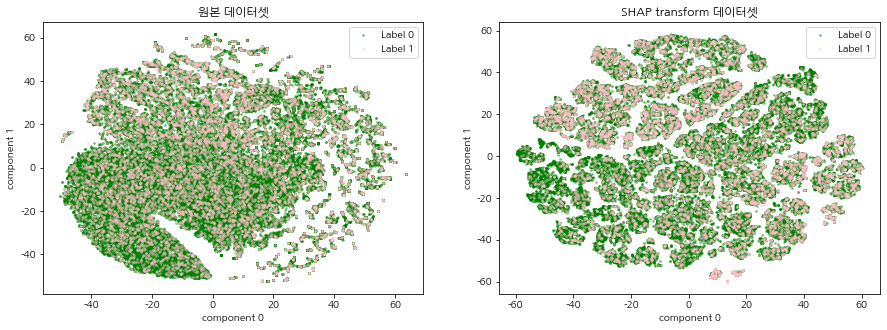

In [33]:
tsne_visualization(dataset=df_data_2, shap_dataset=df_shap_values_2, year=2019, cci_type=2, tsne_load=True, alpha=0.4, size=3)

#### II. 2020

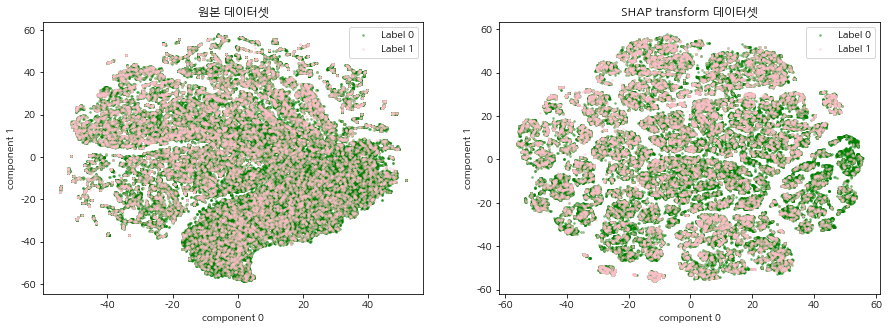

In [32]:
tsne_visualization(dataset=df_data_2, shap_dataset=df_shap_values_2, year=2020, cci_type=2, tsne_load=True, alpha=0.4, size=3)

#### III. 2021

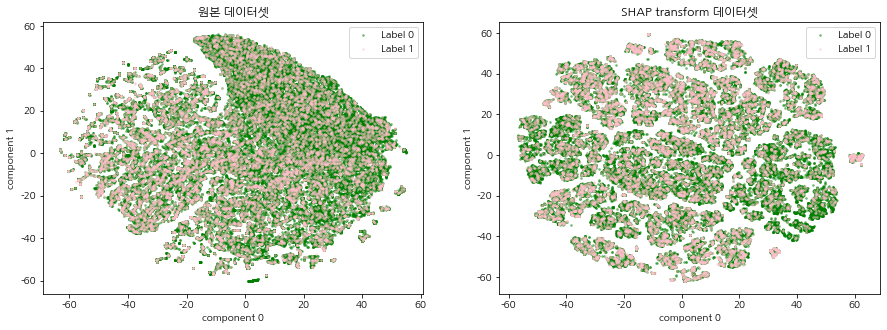

In [31]:
tsne_visualization(dataset=df_data_2, shap_dataset=df_shap_values_2, year=2021, cci_type=2, tsne_load=True, alpha=0.4, size=3)

<br>

### 3) 침체구간/과매도구간 - CCI : (- ∞ ,-100)

#### I. 2019

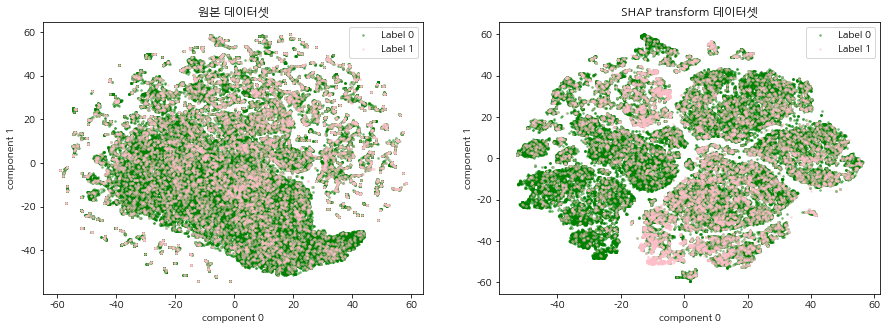

In [30]:
tsne_visualization(dataset=df_data_3, shap_dataset=df_shap_values_3, year=2019, cci_type=3, tsne_load=True, alpha=0.4, size=3)

#### II. 2020

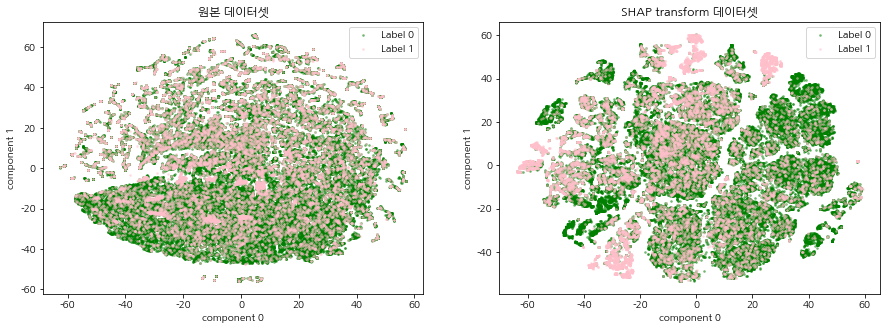

In [29]:
tsne_visualization(dataset=df_data_3, shap_dataset=df_shap_values_3, year=2020, cci_type=3, tsne_load=True, alpha=0.4, size=3)

#### III. 2021

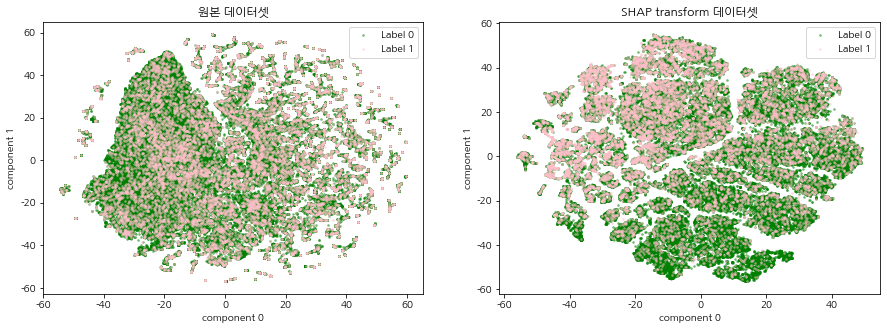

In [28]:
tsne_visualization(dataset=df_data_3, shap_dataset=df_shap_values_3, year=2021, cci_type=3, tsne_load=True, alpha=0.4, size=3)

모든 CCI 구간, 연도에서 원본 주가 데이터셋 보다 `SHAP 표준화 데이터셋`의 군집의 경계가 더 명확하게 드러났으며, 특정 label의 분포 또한 집중되어있는 군집이 존재함을 확인할 수 있다. 이는 SHAP 표준화 데이터셋을 사용함으로써, **예측 모델의 중요 변수를 상대적으로 가중하게되어 데이터에서의 내재되어있는 패턴이 강조되는 효과**가 나타난 것으로 해석된다. 본 글에서 군집이 나누어지는 것을 확인하였다면, 다음 글에서는 `SHAP 표준화 데이터셋`에 대하여 실제로 클러스터링 알고리즘을 적용하여 군집을 명시적으로 분류하는 시간을 가진다. 